# Replicate focus- and single-cell gate from IDEAS using the SCI feature extraction tool

In [31]:
import pandas
import matplotlib.pyplot as plt
import seaborn
import umap
import sqlite3
from ehv import core

In [32]:
db_file = "data/sc_gate_allCtrl.sqlite3"

In [33]:
df = core.load_from_sqlite_db(db_file)

In [34]:
df["feat_haralickContrast_0"] = df.filter(regex="feat_haralickContrast.*_0").mean(axis=1)

In [35]:
df.head()

,feat_min_0,feat_haralickEntropyHORIZONTAL_5,feat_min_6,feat_haralickEntropyHORIZONTAL_6,feat_min_3,feat_min_5,feat_haralickEntropyVERTICAL_6,feat_haralickEntropyHORIZONTAL_0,feat_haralickEntropyVERTICAL_5,feat_haralickEntropyHORIZONTAL_3,...,feat_max_0,feat_haralickContrastHORIZONTAL_3,feat_max_6,feat_haralickContrastHORIZONTAL_0,feat_max_5,feat_tamuraContrast_10,meta_replicate,meta_timepoint,meta_fiji,feat_haralickContrast_0
0,754,4.494071,37,4.487347,27,25,4.482653,4.703664,4.735585,3.750785,...,962,223.094891,234,288.737226,126,28.672292,C3,5,31,288.903443
1,745,4.376188,32,4.594803,24,25,4.545932,4.827261,4.602216,3.882469,...,886,121.176471,303,276.639706,177,34.724980,C3,5,19,293.826575
2,745,4.661803,37,4.873306,25,26,4.891705,4.957409,4.918806,3.581225,...,955,201.981928,305,332.692771,81,24.374255,C3,5,1,355.082322
3,726,5.012788,43,5.078610,24,25,5.065749,5.400166,5.142924,4.368171,...,875,124.484252,353,166.862205,213,40.467731,C3,5,5,168.596015
4,671,4.319667,31,5.463857,23,25,5.452105,5.543997,4.681868,4.285808,...,971,162.811828,436,170.860215,297,56.560989,C3,5,3,158.922043


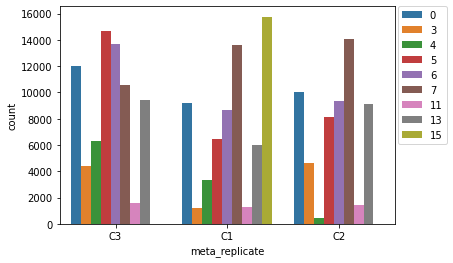

In [36]:
seaborn.countplot(data=df, x="meta_replicate", hue="meta_timepoint", hue_order=sorted(df["meta_timepoint"].unique())).legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

Cell counts per file vary widely. This could pose a problem if we expect changes to occur in the control samples as time progresses.

Next, we plot size in function of roundness. A good gate for selecting images containing single cells.

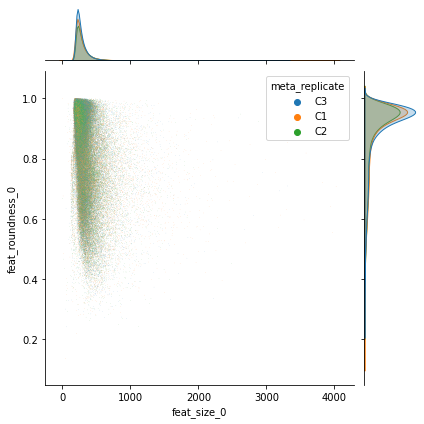

In [37]:
seaborn.jointplot(data=df, x="feat_size_0", y="feat_roundness_0", hue="meta_replicate", s=0.1)

In [38]:
df["feat_size_0"].describe()

count    195353.000000
mean        293.492181
std         139.277193
min           4.000000
25%         219.500000
50%         253.500000
75%         316.000000
max        4023.500000
Name: feat_size_0, dtype: float64

We want to filter out very small datapoints, regardless of their roundness. 50 seems a good cut-off from inspecting the dataset.

For the roundness we want to select cells in [0.8 - 1.0].

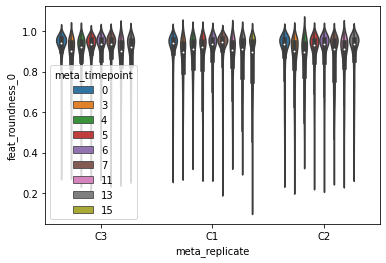

In [39]:
seaborn.violinplot(data=df, x="meta_replicate", y="feat_roundness_0", hue="meta_timepoint")

In [40]:
roundness_stats = df.groupby(["meta_timepoint", "meta_replicate"])["feat_roundness_0"].agg(["mean", "std"])
roundness_lower_bound = roundness_stats["mean"] - 2*roundness_stats["std"]

In [41]:
df_gate1 = df[
    (df["feat_roundness_0"] > 0.8) &
    (df["feat_size_0"] > 50)
]

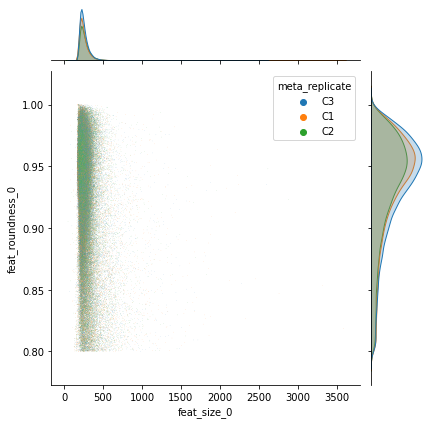

In [42]:
seaborn.jointplot(data=df_gate1, x="feat_size_0", y="feat_roundness_0", hue="meta_replicate", s=0.1)

In [43]:
df.shape

(195353, 107)

In [44]:
df_gate1.shape

(156111, 107)

In [46]:
from importlib import reload
reload(core)

<module 'ehv.core' from '/data/dev/active/EhV-analysis/ehv/core.py'>

In [47]:
core.add_gating_table(db_file)

In [48]:
core.add_gate(db_file, "gate1", df_gate1)

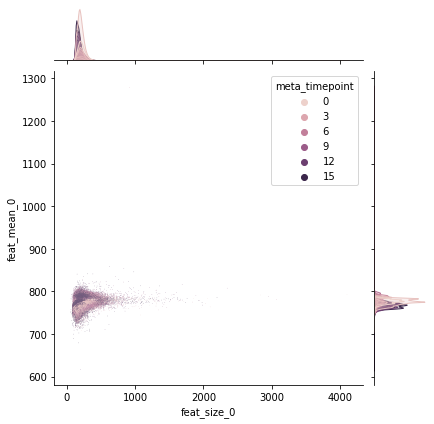

In [17]:
grid = seaborn.jointplot(data=df_gate1, x="feat_size_0", y="feat_mean_0", s=0.2, hue="meta_timepoint")


In [15]:
df_gate2 = df[(df["feat_size_0"] > 150) & (df["feat_size_0"] < 400) & (df["feat_roundness_0"] > 0.85)]

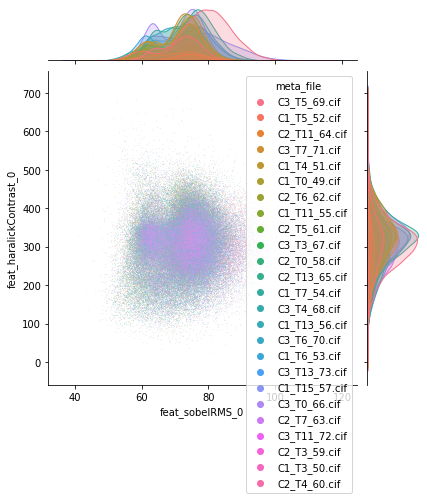

In [16]:
seaborn.jointplot(data=df_gate2, x="feat_sobelRMS_0", y="feat_haralickContrast_0", hue="meta_file", s=0.2)

In [74]:
df_gate2[df_gate2["feat_sobelRMS_0"] < 65].filter(regex="meta")

,meta_file,meta_directory,meta_id,meta_fiji
12,C3_T0_66.cif,/home/maximl/personal/data/Ctrl/C3_T0_66.cif,22,45
17,C3_T0_66.cif,/home/maximl/personal/data/Ctrl/C3_T0_66.cif,21,43
18,C3_T0_66.cif,/home/maximl/personal/data/Ctrl/C3_T0_66.cif,20,41
26,C3_T0_66.cif,/home/maximl/personal/data/Ctrl/C3_T0_66.cif,27,55
33,C3_T0_66.cif,/home/maximl/personal/data/Ctrl/C3_T0_66.cif,40,81
...,...,...,...,...
39887,C2_T0_58.cif,/home/maximl/personal/data/Ctrl/C2_T0_58.cif,19886,39773
39889,C2_T0_58.cif,/home/maximl/personal/data/Ctrl/C2_T0_58.cif,19889,39779
39917,C2_T0_58.cif,/home/maximl/personal/data/Ctrl/C2_T0_58.cif,19915,39831
39935,C2_T0_58.cif,/home/maximl/personal/data/Ctrl/C2_T0_58.cif,19929,39859


In [75]:
df_gate2[df_gate2["feat_sobelRMS_0"] > 80].filter(regex="meta")

,meta_file,meta_directory,meta_id,meta_fiji
0,C3_T0_66.cif,/home/maximl/personal/data/Ctrl/C3_T0_66.cif,16,33
4,C3_T0_66.cif,/home/maximl/personal/data/Ctrl/C3_T0_66.cif,7,15
40,C3_T0_66.cif,/home/maximl/personal/data/Ctrl/C3_T0_66.cif,45,91
85,C3_T0_66.cif,/home/maximl/personal/data/Ctrl/C3_T0_66.cif,87,175
86,C3_T0_66.cif,/home/maximl/personal/data/Ctrl/C3_T0_66.cif,91,183
...,...,...,...,...
39916,C2_T0_58.cif,/home/maximl/personal/data/Ctrl/C2_T0_58.cif,19917,39835
39944,C2_T0_58.cif,/home/maximl/personal/data/Ctrl/C2_T0_58.cif,19944,39889
39954,C2_T0_58.cif,/home/maximl/personal/data/Ctrl/C2_T0_58.cif,19953,39907
39965,C2_T0_58.cif,/home/maximl/personal/data/Ctrl/C2_T0_58.cif,19965,39931


# Comparing gradient and texture features

Gradient features are used to detect images with high contrast and texture. Current texture related features in the feature set are:
- haralickContrast
- haralickCorrelation
- haralickEntropy
- tamuraContrast
- sobelRMS
- gradientRMS

In [12]:
df = pandas.read_csv("data/output-texture.csv")

In [16]:
df["feat_haralickContrast_0"] = df.filter(regex="feat_haralickContrast.*_0").mean(axis=1)
df["feat_haralickEntropy_0"] = df.filter(regex="feat_haralickEntropy.*_0").mean(axis=1)
df["feat_haralickCorrelation_0"] = df.filter(regex="feat_haralickCorrelation.*_0").mean(axis=1)

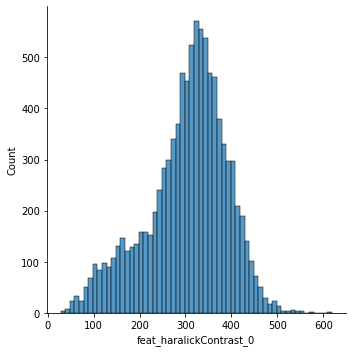

In [17]:
seaborn.displot(df["feat_haralickContrast_0"])

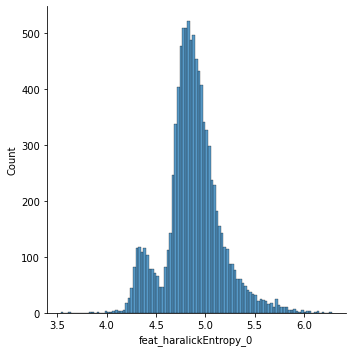

In [18]:
seaborn.displot(df["feat_haralickEntropy_0"])

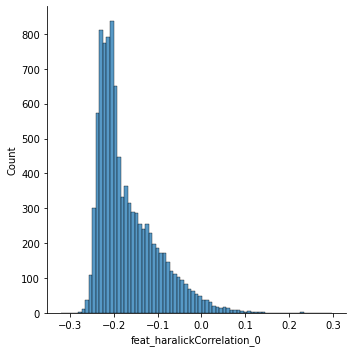

In [20]:
seaborn.displot(df["feat_haralickCorrelation_0"])

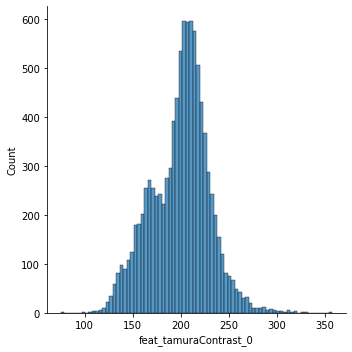

In [21]:
seaborn.displot(df["feat_tamuraContrast_0"])

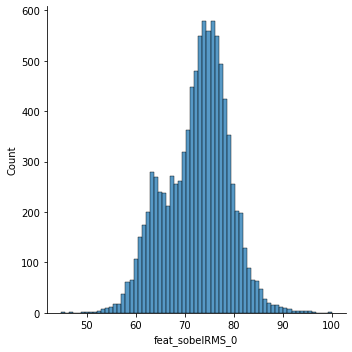

In [22]:
seaborn.displot(df["feat_sobelRMS_0"])

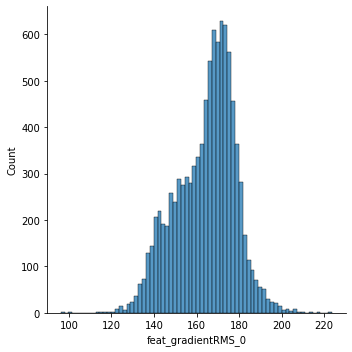

In [24]:
seaborn.displot(df["feat_gradientRMS_0"])

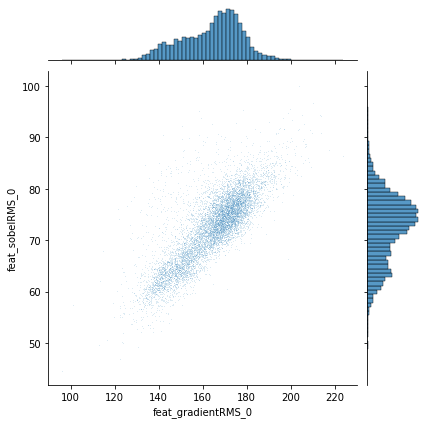

In [26]:
seaborn.jointplot(data=df, x="feat_gradientRMS_0", y="feat_sobelRMS_0", s=0.2)

## Comparing gradientRMS with different kernel sizes

In [27]:
df = pandas.read_csv("data/output-gradient.csv")

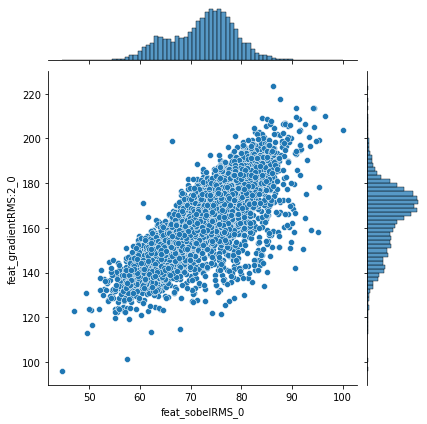

In [36]:
seaborn.jointplot(data=df, x="feat_sobelRMS_0", y="feat_gradientRMS:2_0")